<a href="https://colab.research.google.com/github/qoraraf/Astronomy-exoplanets/blob/main/Exoplanets_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hunting for exoplanet with machine  learning**

## **Description of the dataset [Kaggle]**

The data describe the change in flux (light intensity) of several thousand stars. Each star has a binary label of 2 or 1. 2 indicated that that the star is confirmed to have at least one exoplanet in orbit; some observations are in fact multi-planet systems.

As you can imagine, planets themselves do not emit light, but the stars that they orbit do. If said star is watched over several months or years, there may be a regular 'dimming' of the flux (the light intensity). This is evidence that there may be an orbiting body around the star; such a star could be considered to be a 'candidate' system. Further study of our candidate system, for example by a satellite that captures light at a different wavelength, could solidify the belief that the candidate can in fact be 'confirmed'.


**Trainset:**

5087 rows or observations.
3198 columns or features.
Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
37 confirmed exoplanet-stars and 5050 non-exoplanet-stars.

**Testset:**

570 rows or observations.
3198 columns or features.
Column 1 is the label vector. Columns 2 - 3198 are the flux values over time.
5 confirmed exoplanet-stars and 565 non-exoplanet-stars.

[Download dataset](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data/download?datasetVersionNumber=3)

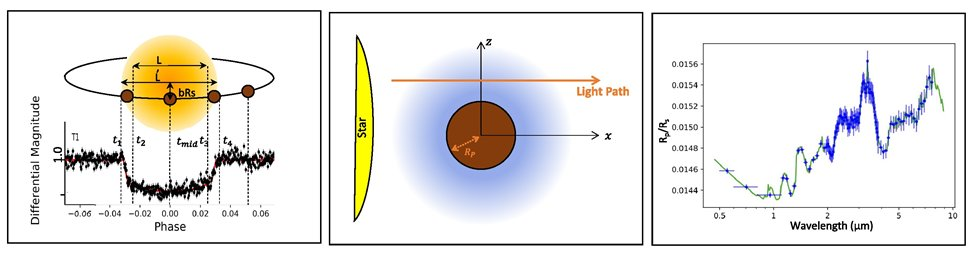

## **Loading dataset and preprocessing**

In [ ]:
import pandas as pd
import numpy as np
# Load training dataset
file_path = "/content/drive/MyDrive/Colab Notebooks/astronomy data/exoTrain.csv"
df = pd.read_csv(file_path)


In [ ]:
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
print(df.info(),"\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5087 entries, 0 to 5086
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 124.1 MB
None 



In [ ]:
#Check for mising values:
df.isnull().values.any()


False

In [ ]:
# check for imbalance

df['LABEL'].value_counts()


LABEL
1    5050
2      37
Name: count, dtype: int64

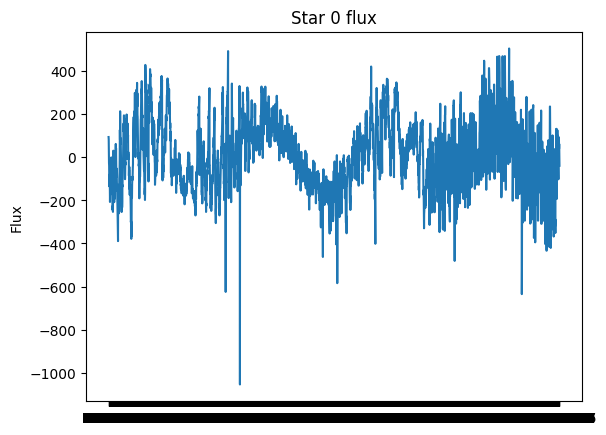

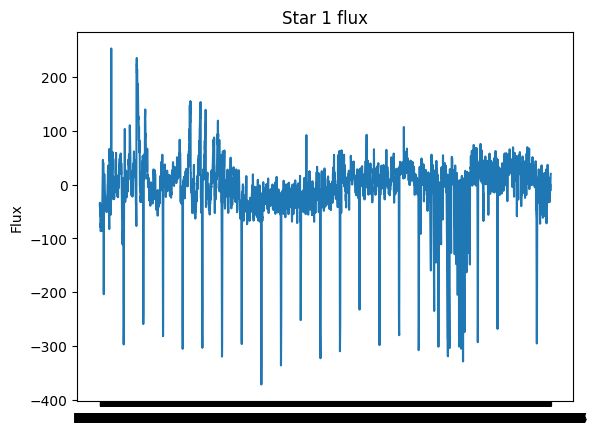

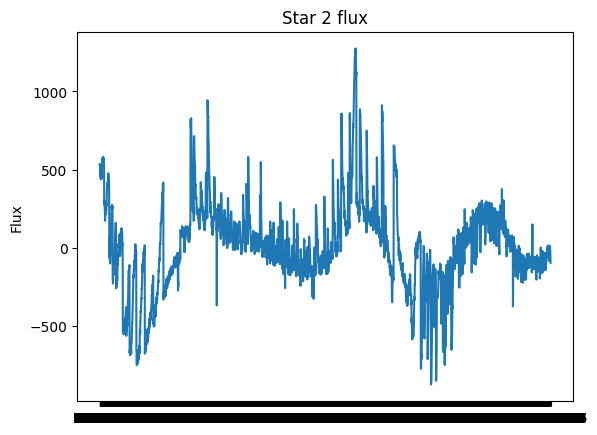

In [ ]:
import matplotlib.pyplot as plt

# Plot the fluxes for the first 3 stars
for i in range(0,3):
  fluxes = df.iloc[i, 1:]
  plt.plot(fluxes)
  plt.ylabel('Flux')
  plt.title(f"Star {i} flux")
  plt.show()


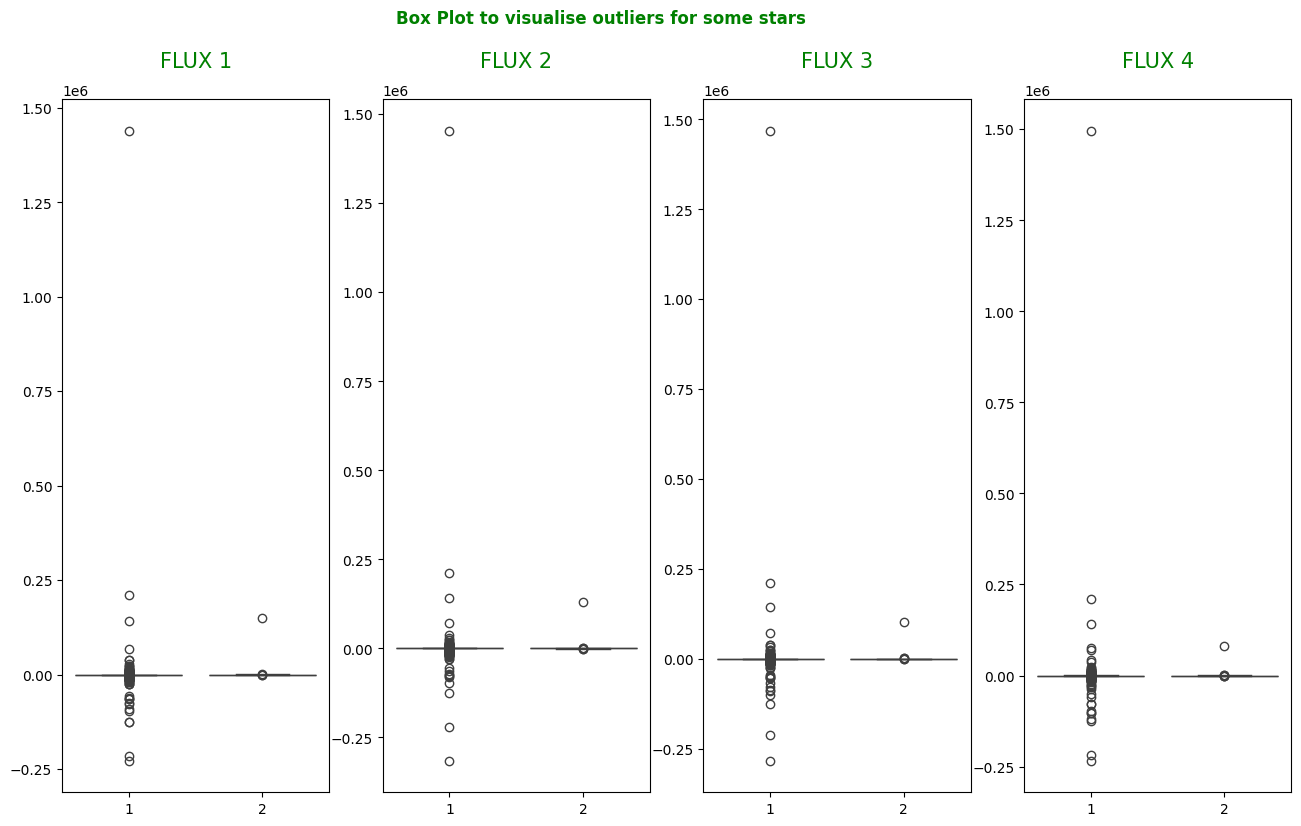

In [ ]:
import seaborn as sns
plt.figure(figsize = (20, 9))
plt.suptitle("Box Plot to visualise outliers for some stars ", ha = 'right', color = 'green', weight = 'bold')
for i in range(1, 5):
    plt.subplot(1, 5, i)
    sns.boxplot(data=df, x='LABEL', y = 'FLUX.' + str(i))
    plt.xlabel("")
    plt.ylabel("")
    plt.title("FLUX " + str(i) + "\n", color = 'g', fontsize = 15)

In [ ]:

df = df[df['FLUX.1'] < 1e6]


In [ ]:

# Calculate the interquartile range (IQR) for each flux column
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers based on the IQR
df = df[(df < (Q3 + 1.5 * IQR)) | (df > (Q1 - 1.5 * IQR))]


In [ ]:
IQR

LABEL         0.0000
FLUX.1       90.5925
FLUX.2       83.7225
FLUX.3       80.7800
FLUX.4       74.7550
              ...   
FLUX.3193    55.2875
FLUX.3194    44.8850
FLUX.3195    42.8250
FLUX.3196    40.5750
FLUX.3197    40.0800
Length: 3198, dtype: float64

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Encode labels to be in {0, 1}
df['LABEL'] = df['LABEL'] - 1

X = df.drop('LABEL', axis=1)
y = df['LABEL']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Considering the high imbalanced data compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

ValueError: classes should include all valid labels that can be in y

In [ ]:
class_weights_dict

In [ ]:
# Initialize and train the SVM model
model = SVC(kernel='rbf', class_weight=class_weights_dict, C=1.0, random_state=42)
model.fit(X_train_scaled, y_train)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [ ]:
#print confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


In [ ]:
#print confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


In this analysis, I used a Support Vector Machine (SVM) model to classify stars based on their fluxes to detect the presence of exoplanets. Given the imbalanced nature of the dataset, where instances of one class (no-exoplanets) significantly outnumber those of the other (with exoplanets), achieving high accuracy on both classes proved challenging. Despite achieving an overall high accuracy, the model's performance on the minority class was unsatisfactory, as shown by low recall and F1 scores. This discrepancy means that the model's tends to favor the majority class, which makes it necessary to look for a more balanced approach to classification.

To address this problem, I will conduct parameter tuning using GridSearchCV, focusing on the C and gamma parameters of the SVM. These parameters play crucial roles in controlling the trade-off between classifying training points correctly and having a smooth decision boundary, and in determining the influence of individual support vectors, respectively. By optimizing these parameters the model's generalization ability and its performance on the minority class should improve, making it more robust and reliable for detecting exoplanets in this dataset.

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']  # Exploring only RBF kernel in this grid
}

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
svc = SVC(class_weight='balanced')  # To handle imbalanced data
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train_scaled, y_train)

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

# check for the F1 score
from sklearn.metrics import f1_score
print("F1 Score on Test Set:", f1_score(y_test, y_pred))

F1 Score on Test Set is 0.0: Despite the parameter tuning, the F1 score on the test set is 0.0. This indicates that the model, even with the best parameters found, failed to correctly identify any instances of the minority class in the test data. An F1 score of 0 implies either poor recall, poor precision, or both, specifically for the minority class. In this case, it could mean that the model did not correctly predict any true positives for the minority class or that the predictions it did make were all incorrect. And the relatively low value of the best F1 score suggests that the model struggles to effectively balance precision and recall for the minority class.

In [ ]:
!pip install lazypredict


In [ ]:
import lazypredict
from lazypredict.Supervised import LazyClassifier


In [ ]:
clf = LazyClassifier(verbose=0,ignore_warnings=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

In [ ]:
# prompt: return best model for both accuracy and f1 score

best_model_accuracy = max(models, key=lambda model: model['Accuracy'])
best_model_f1 = max(models, key=lambda model: model['F1 Score'])

print("Best Model for Accuracy:", best_model_accuracy['Model'])
print("Best Model for F1 Score:", best_model_f1['Model'])


**Testing with LogisticRegression**

In [ ]:
from sklearn.model_selection import

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create a LogisticRegression object
lr = LogisticRegression()

# Fit the model to the training data
lr.fit(X_train, y_train)
# PRedict
y_pred_lr = lr.predict(X_test)

In [ ]:
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

In [ ]:
from lightgbm import LGBMClassifier

# Create a LGBMClassifier object
lgbm = LGBMClassifier()

# Fit the model to the training data
lgbm.fit(X_train, y_train)

# Predict
y_pred_lgbm = lgbm.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))
